# Eploratory Data Analysis

--- 
### Table of contents

#### Section 1: r/DMAcademy and r/truezelda post analysis
1. [Identify custom stop words](#1-stop-words)
2. [Word counts of posts](#1-word-count)
3. [Character length of posts](#1-character-len)
4. [Sentiment analysis using NLTK](#1-sentiment)
    * 4.1 [Workflow sample of word tokenizing](#1-token-workflow)
    * 4.2 [Sentiment analysis](#1-polarity)


#### Section 2: r/PoliticalDiscussion comment analysis
1. [Identify custom stop words](#2-stop-words)
2. [Word counts of posts](#2-word-count)
3. [Character length of posts](#2-character-len)
4. [Sentiment analysis using NLTK](#2-sentiment)

---

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
# import re

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Make our plots pretty
sns.set()

<a id='1-stop-words'></a>

---
# Section 1: DMAcademy and truezelda text analysis


### Read in the data files

In [2]:
dmacademy_df = pd.read_csv('../data/clean_dmacademy.csv')
truezelda_df = pd.read_csv('../data/clean_truezelda.csv')

### Identify potential stop words

[Stop words](https://en.wikipedia.org/wiki/Stop_word) are words that we filter out of our text during the preprocessing steps of language processing and analysis. To get us started, we can rely on sklearn's list of english stop words, accessible by importing `text` from [sklearn's feature extraction module](https://scikit-learn.org/stable/modules/feature_extraction.html). This will filter out some common english words, but we can identify more to add to the list manually. For example, r/DMAcademy and r/truezelda are both subreddits focused on games, so the word 'game' probably won't inform our model on which subreddit a post came from. My goal for this section of my EDA is to identify the most common words shared by these subreddit and add them to our list of stop words to filter out before modeling. We can do this by using sklearn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize the posts from each subreddit, then sort the vectorized words into a list and print out the 25 most frequently occurring words of each subreddit. 

In [3]:
# combine title and text into one column to make text analysis simpler
dm_text = dmacademy_df['title'] + ' ' + dmacademy_df['text']
zelda_text = truezelda_df['title'] + ' ' + truezelda_df['text']

In [4]:
# get standard stop words

# uncomment and run the line below to get a longggg list of words
# text.ENGLISH_STOP_WORDS

To find the most common words in each dataframe we need to vectorize them. `CountVectorier` requires a fit and transform, so we should isntantiate and fit a unique instance of the vectorizer for each dataframe.

In [5]:
# vectorize the dataframes using unique count vectorizers

cvec1 = CountVectorizer(stop_words='english')
dm_text_cv = cvec1.fit_transform(dm_text)

cvec2 = CountVectorizer(stop_words='english')
zelda_text_cv = cvec2.fit_transform(zelda_text)

In [6]:
# print some to make sure it worked
cvec1.get_feature_names()[1000:1010]

['approaches',
 'approaching',
 'appropiately',
 'appropriate',
 'appropriately',
 'appropriation',
 'approval',
 'approve',
 'approved',
 'approvement']

Now that our dataframes have been transformed into sparse matrices we can get lists of the most frequently used words in each subreddit. First, we have to turn our sparse matrix into a dataframe using the `todense()` function, then we can use that dataframe to make some plots.

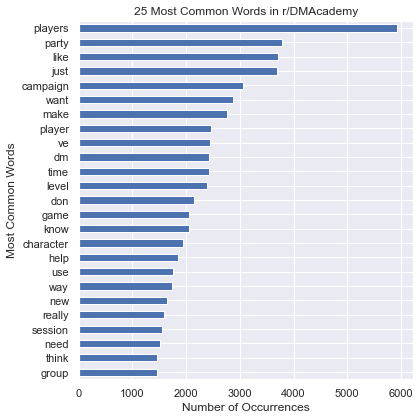

In [7]:
dm_text_df = pd.DataFrame(dm_text_cv.todense(), columns = cvec1.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
dm_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.ylabel('Most Common Words')
plt.title('25 Most Common Words in r/DMAcademy')
plt.tight_layout()
plt.savefig('../visualizations/dmacademy_common_words.png')

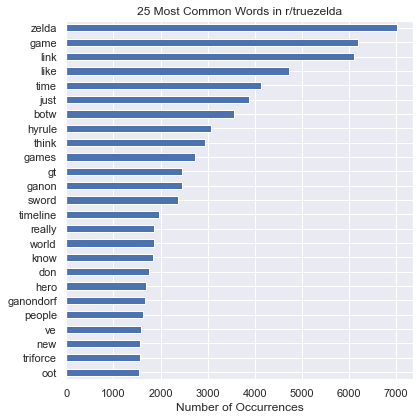

In [8]:
zelda_text_cv = pd.DataFrame(zelda_text_cv.todense(), columns = cvec2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
zelda_text_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

plt.title('25 Most Common Words in r/truezelda')
plt.tight_layout()
plt.savefig('../visualizations/truezelda_common_words.png')

I immediately noticed a handful of very common words that are shared between the two subreddits: 'game', 'games', 'know', 'really', 'think', 'time', and so on. The workflow here is to identify commmons words, append them to our stop word list, pass them as stop words to our count vectorizer to filter out, and print out the new most common words. I had to iterate through this process several times to get two lists of unique common words. This will improve our model's ability to identify one subreddit from the other. I also filtered out single letters in case there were any artifacts from removing punctuation in the previous notebook. For example, the word 'don't' became 'don' and 't', which isn't right. Instead of trying to relpace these words with their not conjugated forms, I'm going to let me stop words list filter them out. 

In [9]:
# Create custom stop word list
custom_words = ['like', 'just', 've', 'don', 'll', 'game', 'games', 'a', 'b', 'c', 'd', 
                'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
                's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'know', 'really', 'new', 'think',
               'things', 'want', 'make', 'way', 'feel', 'world', 'time']

In [10]:
# Join our custom list to sklearn's list of stop words
stop_words = text.ENGLISH_STOP_WORDS.union(custom_words)

In [11]:
cvec1 = CountVectorizer(stop_words=stop_words)
dm_text_cv = cvec1.fit_transform(dm_text)
cvec2 = CountVectorizer(stop_words=stop_words)
zelda_text_cv = cvec2.fit_transform(zelda_text)

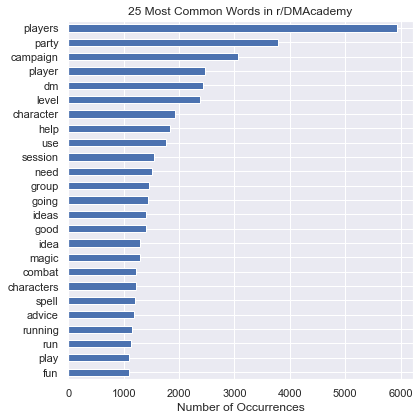

In [12]:
# Create new graphs of common words
dm_text_df = pd.DataFrame(dm_text_cv.todense(), columns = cvec1.get_feature_names())

plt.figure(figsize=(6,6))
# plot top occuring words
dm_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.title('25 Most Common Words in r/DMAcademy')
plt.tight_layout()
plt.savefig('../visualizations/dmacademy_post_stop_words.png')

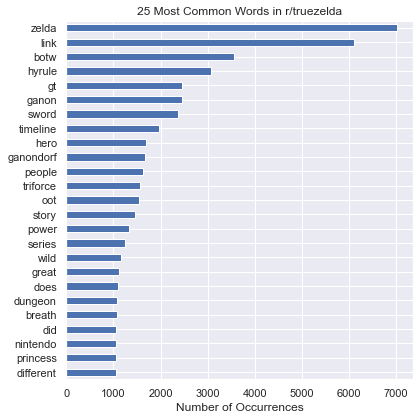

In [13]:
zelda_text_cv = pd.DataFrame(zelda_text_cv.todense(), columns = cvec2.get_feature_names())
plt.figure(figsize=(6,6))
# plot top occuring words
zelda_text_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.title('25 Most Common Words in r/truezelda')
plt.tight_layout()
plt.savefig('../visualizations/truezelda_post_stop_words.png')

Now that the most commonly used words in each subreddit are unique, we can call our stop word list complete for now. Some words here might still be suitable to add to a stop word list, like 'did' or 'does' or 'great', but my goal was met here and I didn't want to lose any more time to identifying stop words. Next time, write a function to do this for you! 

<a id='1-word-count'></a>

---
### Word counts of posts

Another thing to explore is the number of words in each post. Let's see how different the post length is between our two subreddits.

In [14]:
# Inspect our dataframes
dmacademy_df

,subreddit,title,text
0,DMAcademy,Seeking seasoned DMs to be guests on interview...,Edit UPDATE Thank you for the robust respo...
1,DMAcademy,TERRAIN and Using it Effectively,TERRAIN and using it Effectively DM Tips Usi...
2,DMAcademy,Know the exact location of something,The players are planning on dropping an evil a...
3,DMAcademy,How to run military basic as a session,I am running a campaign for all intents and pu...
4,DMAcademy,Best time to take breaks how long they should be,Hey just a newbie DM My sessions are usually ...
...,...,...,...
4882,DMAcademy,Urgently need DM support to appropriately eng...,Hi all I am hoping for some advice please I am...
4883,DMAcademy,Do we help with plot here,Mouseketeers go away So i m stuck on a plot p...
4884,DMAcademy,Where to go next Open to suggestions,I have my first group about to finish Lost Min...
4885,DMAcademy,NPCs Playing against type,I m pretty new to DMing and take very long to ...


In [15]:
truezelda_df

,subreddit,title,text
0,truezelda,With the release of the Xenoblade Chronicles ...,There is a VERY small chance that someone in t...
1,truezelda,Reimagining OoT and MM,Here s an idea what if they made pseudo remake...
2,truezelda,Idea An option in the future DLC to toggle Li...,as improbable as that would be with the movie ...
3,truezelda,Reconciling the Hyrule Compendium entry on Dar...,According to the Hyrule Compendium on DBG it s...
4,truezelda,What would you say are the major themes of eac...,You don t have to list all of them I m just in...
...,...,...,...
4107,truezelda,What happened in the story of the missing link...,I don t really like playing games now but I am...
4108,truezelda,Do you think Blind The Thief is a Sheikah,We know that he lived in Kakariko Village
4109,truezelda,Should games such as Tri Force Heroes and Four...,The Zelda timeline is infamous for being convo...
4110,truezelda,Review score predictions for Skyward HD,Title says it all How will it fare With the o...


Now let's create lists that contain the number of words in each subreddit post

In [16]:
# Use list comprehension 
dma_word_counts = [len(post.split()) for post in dmacademy_df['text']]
zelda_word_counts = [len(post.split()) for post in truezelda_df['text']]

Let's print out a few to make sure things look right. 

In [17]:
dma_word_counts[:10]

[294, 697, 62, 56, 25, 172, 433, 246, 685, 557]

In [18]:
zelda_word_counts[:10]

[111, 264, 24, 201, 26, 58, 125, 1583, 1, 167]

Interesting that there's a post only 1 word long, wonder what that's about.

In [19]:
truezelda_df.iloc[8]

subreddit                                            truezelda
title        How would you feel about a canon entry set dur...
text                                                 Thoughts 
Name: 8, dtype: object

Looks like the title says it all for this post. That's precisely why we're going to be using the titles alongside the text in our model fitting later on! Next, let's finally plot those word counts

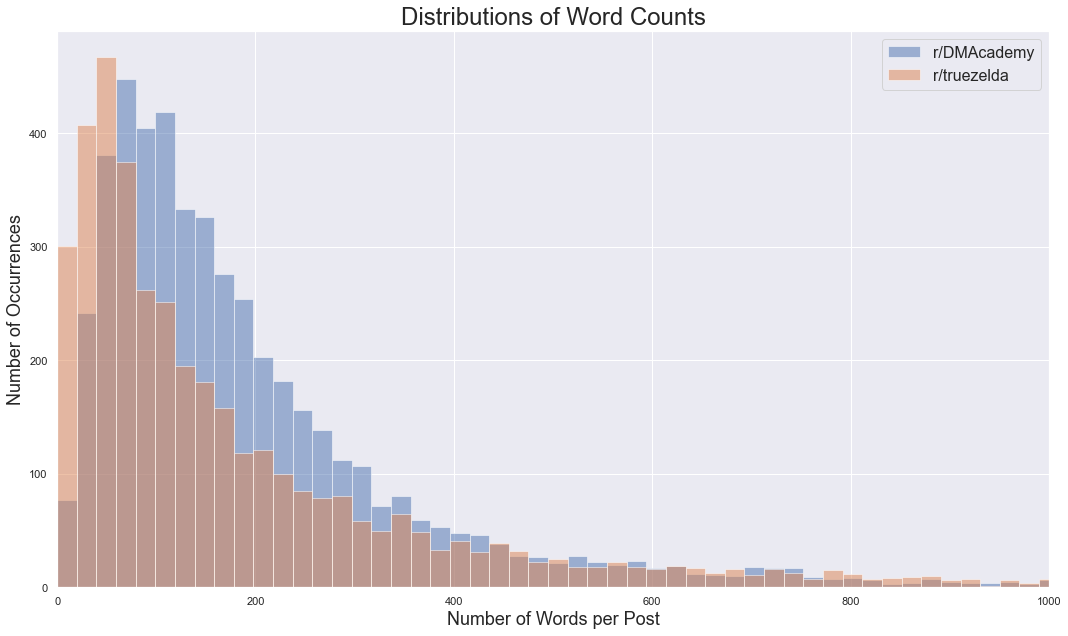

In [20]:
# used custom bin size to get the bin widths to match - 
# this took a lot of trial and error, I would love to find a better way to do it

plt.figure(figsize=(15,9))

plt.hist(dma_word_counts, bins=175, alpha=0.5, label='r/DMAcademy')
plt.hist(zelda_word_counts, bins=315, alpha=0.5, label='r/truezelda')

plt.xlabel('Number of Words per Post', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=18)

plt.title('Distributions of Word Counts', fontsize=24)
plt.legend(fontsize=16)

plt.xlim(0, 1000);

plt.tight_layout()

plt.savefig('../visualizations/word_count_dist.png')

This distribution plot shows us that posts on r/DMAcademy are consistently wordier than posts on r/truezelda, and the majority of posts on each subreddit are fewer than 400 words.

<a id='1-character-len'></a>

---
### Post character length

Next, let's look at the number of characters in each post in both subreddits. Thinking back to our text cleaning, we replaced many characters with spaces, and deleted links and digits altogether, so these numbers will be skewed a bit, but since the same process was done for each subreddit I expect them to be skewed in the same way. I won't worry so much about how accurate these results are since I'm just looking into these relative to each subreddit.

In [21]:
dma_char_length = [len(post) for post in dmacademy_df['text']]
zelda_char_length = [len(post) for post in truezelda_df['text']]

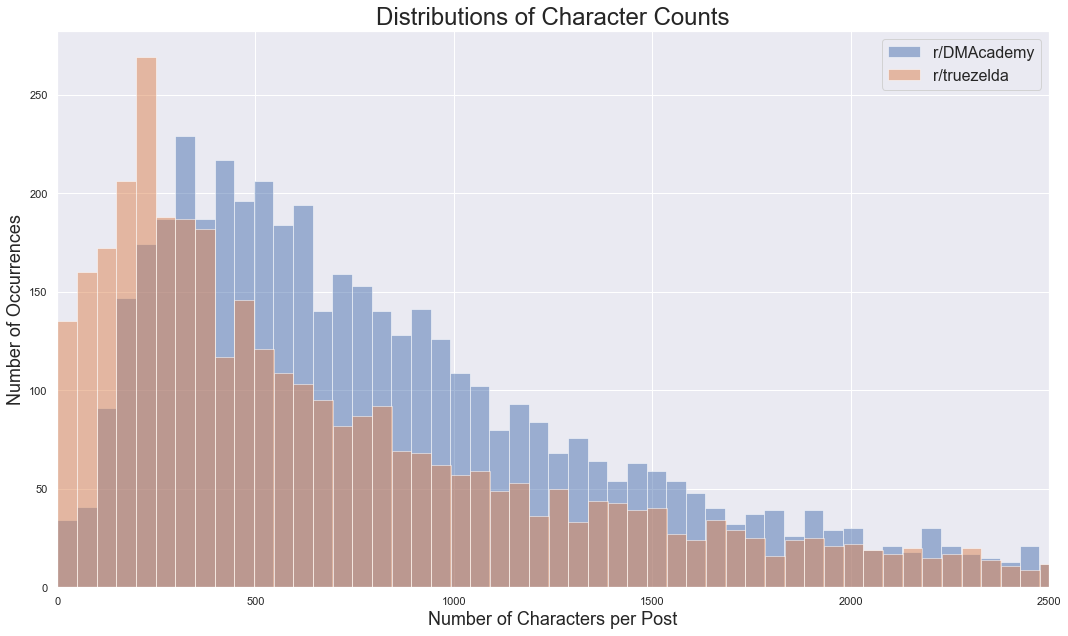

In [22]:
plt.figure(figsize=(15,9))
plt.hist(dma_char_length, bins=400, alpha=0.5, label='r/DMAcademy');
plt.hist(zelda_char_length, bins=650, alpha=0.5, label='r/truezelda');
plt.legend(fontsize=16)
plt.xlabel('Number of Characters per Post', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.title('Distributions of Character Counts', fontsize=24)
plt.xlim(0, 2500);
plt.tight_layout()
plt.savefig('../visualizations/character_count_dist.png')

This distribution plot shows us that r/DMAcademy has consistently more characters per post than r/truezelda. This differences matches our previous word count findings, a good sign! 

<a id='1-sentiment'></a>

---
### Sentiment analysis using NLTK

Now we can finally get to the sentiment analysis! [Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is a technique used in Natural Language Processing (NLP) to understand the sentiment of a post. This means looking at how positive, negative, or neutral the words used in a post are. This technique is often used in branding and marketing to determine how customers feel about a company's products or services. There are a lot of different ways to approach this, and multiple Python libraries exist to accomplish this task. I chose to use the [NLTK library](https://www.nltk.org/) because it's very easy to use.

Before jumping into the sentiment analysis, let's practice some word tokenizing to make sure we know what we're doing

<a id='1-token-workflow'></a>

---
### Workflow sample for word tokenizing

First, download the necessary packages. Then, we can test out our lemmatizing and tokenizing capabilities! 

In [46]:
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/derya/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/derya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/derya/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [47]:
# test out our lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('pythons')

'python'

In [48]:
# print out a short post to tokenize as an example
dmacademy_df['text'][2]

'The players are planning on dropping an evil artefact contained in a lead box into the middle of the ocean but one player is still wanting it as it provides information in exchange for information If the player took Keen Mind feat would they know exactly where is was dumped RAW Or would another feat or help them know where it was '

In [52]:
example = dmacademy_df['text'][2]

In [53]:
print(word_tokenize(example.lower()))

['the', 'players', 'are', 'planning', 'on', 'dropping', 'an', 'evil', 'artefact', 'contained', 'in', 'a', 'lead', 'box', 'into', 'the', 'middle', 'of', 'the', 'ocean', 'but', 'one', 'player', 'is', 'still', 'wanting', 'it', 'as', 'it', 'provides', 'information', 'in', 'exchange', 'for', 'information', 'if', 'the', 'player', 'took', 'keen', 'mind', 'feat', 'would', 'they', 'know', 'exactly', 'where', 'is', 'was', 'dumped', 'raw', 'or', 'would', 'another', 'feat', 'or', 'help', 'them', 'know', 'where', 'it', 'was']


In [54]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|S+')
example_tokens = tokenizer.tokenize(example.lower())

print(example_tokens)

['the', 'players', 'are', 'planning', 'on', 'dropping', 'an', 'evil', 'artefact', 'contained', 'in', 'a', 'lead', 'box', 'into', 'the', 'middle', 'of', 'the', 'ocean', 'but', 'one', 'player', 'is', 'still', 'wanting', 'it', 'as', 'it', 'provides', 'information', 'in', 'exchange', 'for', 'information', 'if', 'the', 'player', 'took', 'keen', 'mind', 'feat', 'would', 'they', 'know', 'exactly', 'where', 'is', 'was', 'dumped', 'raw', 'or', 'would', 'another', 'feat', 'or', 'help', 'them', 'know', 'where', 'it', 'was']


Yep, our tokenizer works! Let's move on.

<a id='1-polarity'></a>

---
### Sentiment analysis

In [ ]:
sentiment = SentimentIntensityAnalyzer()

In [ ]:
example

In [ ]:
sentiment.polarity_scores(example)

In [ ]:
dmacademy_sentiment = {'neg':0, 'neu':0, 'pos':0}
sample_dmacademy = dmacademy_df[:20]

# get polarity scores for each row in our dataframe
for row in sample_dmacademy['text']:
    scores = sentiment.polarity_scores(row)
    dmacademy_sentiment['neg'] += scores['neg']
    dmacademy_sentiment['neu'] += scores['neu']
    dmacademy_sentiment['pos'] += scores['pos']

# get the average for each
for key in dmacademy_sentiment.keys():
    dmacademy_sentiment[key] = dmacademy_sentiment[key]/len(sample_dmacademy)
print(dmacademy_sentiment)

# prove that these add up to close to 1
total = 0
for key in dmacademy_sentiment.keys():
    total += dmacademy_sentiment[key]
total

In [ ]:
def get_polarity(df):
    # create polarity dictionary
    polarity_dict = {'Negative':0, 'Neutral':0, 'Positive':0}
    
    # get polarity scores for each row in our dataframe
    for row in df['text']:
        scores = sentiment.polarity_scores(row)
        polarity_dict['Negative'] += scores['neg']
        polarity_dict['Neutral'] += scores['neu']
        polarity_dict['Positive'] += scores['pos']

    # get the average scores 
    for key in polarity_dict.keys():
        polarity_dict[key] = polarity_dict[key]/len(df)
        
    return polarity_dict

In [ ]:
get_polarity(sample_dmacademy)

In [ ]:
dmacademy_polarity = get_polarity(dmacademy_df)
dmacademy_polarity

In [ ]:
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
cols = list(zip(dmacademy_polarity.keys(), dmacademy_polarity.values()))

polarity_df = pd.DataFrame(cols, columns=['score_type', 'r/DMAcademy'])

In [ ]:
polarity_df

In [ ]:
truezelda_polarity = get_polarity(truezelda_df)
truezelda_polarity

In [ ]:
polarity_df['r/truezelda'] = list(truezelda_polarity.values())

In [ ]:
polarity_df

In [ ]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
polarity_df.plot(x='score_type', y=['r/DMAcademy', 'r/truezelda'], kind='bar', figsize=(9,9));
plt.xlabel('Polarity', fontsize=18)
plt.ylabel('Average Score', fontsize=18)
plt.title('Sentiment Analysis using NLTK', fontsize=24)
plt.legend(fontsize=16)
plt.xticks(rotation=0);
plt.tight_layout()
plt.savefig('../visualizations/polarity_analysis.png')

Now that we've got a small tidy dataframe of our average polarity scores for each subreddit, let's visualize! 

In [ ]:
polarity_df.index

<a id='2-stop-words'></a>

--- 
# Section 2: PoliticalDiscussion 2012 and 2020 text analysis

### Read in the clean data files, again

In [ ]:
poli_dis_2012_df = pd.read_csv('../data/clean_poli_dis_2012.csv')
poli_dis_2020_df = pd.read_csv('../data/clean_poli_dis_2020.csv')

### Identify potential stop words

In [ ]:
poli_dis_2012_df.dropna(inplace=True)
poli_dis_2020_df.dropna(inplace=True)

In [ ]:
poli_2012_text = poli_dis_2012_df['text']
poli_2020_text = poli_dis_2020_df['text']

In [ ]:
# get standard stop words

# uncomment the line below to get a longggg list of words
# text.ENGLISH_STOP_WORDS

In [ ]:
cvec1 = CountVectorizer(stop_words='english')
poli_2012_text_cv = cvec1.fit_transform(poli_2012_text)
cvec2 = CountVectorizer(stop_words='english')
poli_2020_text_cv = cvec2.fit_transform(poli_2020_text)

In [ ]:
# print some to make sure it worked
cvec1.get_feature_names()[1000:1010]

In [ ]:
poli_2012_text_df = pd.DataFrame(poli_2012_text_cv.todense(), columns = cvec1.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2012_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.ylabel('Most Common Words')
plt.savefig('../visualizations/')

In [ ]:
poli_2020_text_df = pd.DataFrame(poli_2020_text_cv.todense(), columns = cvec2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2020_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

In [ ]:
stop_words = text.ENGLISH_STOP_WORDS.union(custom_words)

In [ ]:
cvec1 = CountVectorizer(stop_words=stop_words)
poli_2012_text_cv = cvec1.fit_transform(poli_2012_text)
cvec2 = CountVectorizer(stop_words=stop_words)
poli_2020_text_cv = cvec2.fit_transform(poli_2020_text)

In [ ]:
poli_2012_text_df = pd.DataFrame(poli_2012_text_cv.todense(), columns = cvec1.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2012_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.ylabel('Most Common Words')

In [ ]:
custom_words = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 
                'people', 'gt', 'don', 'll', 've', 'just', 'like', 'think', 'state',
               'government', 'right', 'make', 'way', 'want', 'does', 'doesn', 
               'say', 'know', 'time', 'going', 'really', 'thing', 'didn', 'isn',
               'did', 'actually', 'vote', 'care', 'things', 'work', 'money', 
               'said', 'good', 'point', 'need', 'states', 'lot', 'years']

In [ ]:
poli_2020_text_df = pd.DataFrame(poli_2020_text_cv.todense(), columns = cvec2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2020_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

In [ ]:
poli_dis_2012_df.isnull().sum()

In [ ]:
poli_dis_2012_df.dropna(inplace=True)
poli_dis_2012_df.isnull().sum()

In [ ]:
poli_dis_2020_df.isnull().sum()

In [ ]:
X = poli_dis_2012_df['text']

In [ ]:
cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(X)

In [ ]:
cvec.get_feature_names()[1000:1010]

In [ ]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,12))
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

Words to consider removing: _________

<a id='2-word-count'></a>

---
### Post word count


In [ ]:
poli_dis_2012_counts = [len(post.split()) for post in poli_dis_2012_df['text']]
poli_dis_2020_counts = [len(post.split()) for post in poli_dis_2020_df['text']]

In [ ]:
poli_dis_2012_counts[:10]

In [ ]:
poli_dis_2020_counts[:10]

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(poli_dis_2020_counts, bins=125, alpha=0.5, label='2020');
plt.hist(poli_dis_2012_counts, bins=235, alpha=0.5, label='2012');
plt.legend(fontsize=16)
plt.xlabel('Number of Words per Post', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.title('Distributions of Word Counts', fontsize=24)
plt.xlim(0, 300);
plt.tight_layout()
plt.savefig('../visualizations/poli_word_count_dist.png')

<a id='2-character-len'></a>

---
### Post character length

In [ ]:
poli_dis_2012_char_length = [len(post) for post in poli_dis_2012_df['text']]
poli_dis_2020_char_length = [len(post) for post in poli_dis_2020_df['text']]

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(poli_dis_2020_char_length, bins=200, alpha=0.5, label='2020');
plt.hist(poli_dis_2012_char_length, bins=410, alpha=0.5, label='2012');
plt.legend(fontsize=16)
plt.xlabel('Number of Words per Post', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.title('Distributions of Word Counts', fontsize=24)
plt.xlim(0, 1000);
plt.tight_layout()
plt.savefig('../visualizations/poli_character_count_dist.png')

<a id='2-sentiment'></a>

---
### Sentiment analysis using NLTK

In [ ]:
poli_dis_2012_polarity = get_polarity(poli_dis_2012_df)
poli_dis_2012_polarity

In [ ]:
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
cols = list(zip(poli_dis_2012_polarity.keys(), poli_dis_2012_polarity.values()))

polarity_df = pd.DataFrame(cols, columns=['score_type', '2012'])

In [ ]:
polarity_df

In [ ]:
poli_dis_2020_polarity = get_polarity(poli_dis_2020_df)
poli_dis_2020_polarity

In [ ]:
polarity_df['2020'] = list(poli_dis_2020_polarity.values())

In [ ]:
polarity_df

In [ ]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
polarity_df.plot(x='score_type', y=['2012', '2020'], kind='bar', figsize=(9,9));
plt.xlabel('Polarity')
plt.ylabel('Average Score')
plt.xticks(rotation=0);

---
### Extra stuff
Thought about seeing how many words start with each letter of the alphabet for each of my subreddits. r/truezelda would have a lot more z words, it'd be cool! 

In [ ]:
poli_dis_2020_df.loc[poli_dis_2020_df['text'].str.lower().str.contains('april fool')]['text']

In [ ]:
poli_dis_2012_df.loc[poli_dis_2012_df['text'].str.lower().str.contains('april fool')]['text']

In [ ]:
poli_dis_2012_df.dropna(inplace=True)

In [ ]:
for row in truezelda_df.loc[truezelda_df['text'].str.lower().str.contains('april fool')]['text']:
    print(row)

In [ ]:
for row in dmacademy_df.loc[dmacademy_df['text'].str.lower().str.contains('april fool')]['text']:
    print(row)

In [ ]:
letter_words_dict = {'s':[25333,10.6],
'p':[24472,10.3],
'c':[19851,8.37],
'a':[16869,7.11],
'u':[16520,6.97],
't':[12976,5.47],
'm':[12503,5.27],
'b':[11117,4.69],
'd':[11107,4.68],
'r':[9918,4.18],
'h':[9105,3.84],
'i':[8819,3.72],
'e':[8748,3.69],
'o':[7877,3.32],
'f':[7152,3.01],
'g':[6969,2.94],
'n':[6758,2.85],
'l':[6322,2.66],
'w':[4074,1.71],
'v':[3416,1.44],
'k':[2234,0.94],
'j':[1637,0.69],
'q':[1179,0.49],
'z':[963,0.40],
'y':[680,0.28],
'x':[384,0.16]}